<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Эло" data-toc-modified-id="Эло-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Эло</a></span></li><li><span><a href="#Выделение-признаков" data-toc-modified-id="Выделение-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выделение признаков</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Предикт-для-новых-данных" data-toc-modified-id="Предикт-для-новых-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Предикт для новых данных</a></span></li><li><span><a href="#Предикт-на-новых-данных" data-toc-modified-id="Предикт-на-новых-данных-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Предикт на новых данных</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from catboost import CatBoostRegressor, Pool, cv
# from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pickle
%matplotlib inline

### Подготовка

In [2]:
pd.options.display.max_rows = 200
pd.set_option('display.max_columns', None)
tab = pd.read_csv('general_info.csv')

In [3]:
tab.isna().sum()

id_season                         0
id_match                          0
id_regular                        0
start_time                        0
location                          0
viewers                           0
coach_home                        0
coach_away                        0
referee_1                        19
referee_2                      1159
linesman_1                        0
linesman_2                        1
team_home                         0
team_away                         0
G_home                            1
G_away                            0
end_match                         0
G_home_1per                       0
G_away_1per                       0
G_home_2per                       0
G_away_2per                       0
G_home_3per                       0
G_away_3per                       0
G_home_OT                      9944
G_away_OT                      9944
G_home_SO                     11433
G_away_SO                     11433
G_home_RT                   

In [4]:
# правка для матча №247 Витязь-Трактор сезона 08-09. Матч был сыгран практически полностью. На 59-36 была массовая драка
tab.loc[246, ['G_home', 'G_away', 'end_match']] = [3, 1, 'RT']
tab['G_home'] = tab['G_home'].astype('int')

In [5]:
team_name_dict = {
        'Адмирал' : 'ADM',
        'Ак Барс' : 'AKB', 
        'Амур' : 'AMR', 
        'Авангард' : 'AVG', 
        'Автомобилист' : 'AVT', 
        'Барыс' : 'BAR', 
        'ЦСКА' : 'CSKA', 
        'Динамо Мн' : 'DMN', 
        'Динамо Р' : 'DRG', 
        'Динамо М' : 'DYN', 
        'Куньлунь РС' : 'KRS', 
        'Локомотив' : 'LOK', 
        'Металлург Мг' : 'MMG', 
        'Нефтехимик' : 'NKH', 
        'Салават Юлаев' : 'SAL', 
        'ХК Сочи' : 'SCH', 
        'Северсталь' : 'SEV', 
        'Сибирь' : 'SIB', 
        'СКА' : 'SKA', 
        'Спартак' : 'SPR', 
        'Торпедо НН' : 'TOR',
        'Торпедо' : 'TOR',
        'Трактор' : 'TRK', 
        'Витязь' : 'VIT', 
        'Йокерит' : 'YOK', 
        'Медвешчак' : 'MDV', 
        'Металлург Нк' : 'MNK', 
        'Югра' : 'UGR', 
        'Слован' : 'SLV', 
        'Лада' : 'LAD', 
        'Атлант' : 'ATL', 
        'Лев Пр' : 'LEV',
        'Лев Пп' : 'LEV',
        'ХК МВД' : 'MVD', 
        'Донбасс' : 'DON', 
        'Химик' : 'HIM'}

In [6]:
# ренейминг команд на краткие аббривиатуры
for col in ['team_home', 'team_away']:
    tab = tab.replace({col:team_name_dict})

In [7]:
# оставляем матчи только с аббривиатурами команд КХЛ, убирая из данных матчи всех звезд
tab = tab[tab['team_home'].isin(team_name_dict.values())]
tab = tab[tab['team_away'].isin(team_name_dict.values())].reset_index(drop=True)

In [8]:
# создаем колонку с номером сезона
tab['season'] = tab['id_season'].apply(lambda x: int(x[3:5]))
# создаем булеву колонку с указанием для матчей плей офф
tab['is_playoff'] = tab['id_season'].apply(lambda x: 1 if x[6:8] == 'PO' else 0)
# изменяем на временной тип данных для времени начала матча
tab['start_time'] = pd.to_datetime(tab['start_time'], format='%d.%m.%Y %H:%M')
# добавляем колонку с датой начала матча
tab['day'] = tab['start_time'].dt.date

In [9]:
# добавляем колонку с нумерацией игрового дня
tab['num_day'] = tab[['season', 'day']].groupby('season').rank(method='dense').astype(int)

In [10]:
tab.describe()

,id_match,id_regular,viewers,G_home,G_away,G_home_1per,G_away_1per,G_home_2per,G_away_2per,G_home_3per,G_away_3per,G_home_OT,G_away_OT,G_home_SO,G_away_SO,G_home_RT,G_away_RT,G_home_5on5,G_home_5on4,G_home_5on3,G_home_4on4,G_home_4on3,G_home_3on3,G_home_3on4,G_home_3on5,G_home_4on5,G_home_EN,G_home_bul,G_away_5on5,G_away_5on4,G_away_5on3,G_away_4on4,G_away_4on3,G_away_3on3,G_away_3on4,G_away_3on5,G_away_4on5,G_away_EN,G_away_bul,SOG_home,SOG_away,SOG_home_1per,SOG_away_1per,SOG_home_2per,SOG_away_2per,SOG_home_3per,SOG_away_3per,SOG_home_OT,SOG_away_OT,SOG_home_RT,SOG_away_RT,BLK_home,BLK_away,BLK_home_1per,BLK_away_1per,BLK_home_2per,BLK_away_2per,BLK_home_3per,BLK_away_3per,BLK_home_OT,BLK_away_OT,BLK_home_RT,BLK_away_RT,HIT_home,HIT_away,HIT_home_1per,HIT_away_1per,HIT_home_2per,HIT_away_2per,HIT_home_3per,HIT_away_3per,HIT_home_OT,HIT_away_OT,HIT_home_RT,HIT_away_RT,attack_time_home,attack_time_away,attack_time_home_1per,attack_time_away_1per,attack_time_home_2per,attack_time_away_2per,attack_time_home_3per,attack_time_away_3per,attack_time_home_OT,attack_time_away_OT,attack_time_home_RT,attack_time_away_RT,control_time_home,control_time_away,control_time_home_1per,control_time_away_1per,control_time_home_2per,control_time_away_2per,control_time_home_3per,control_time_away_3per,control_time_home_OT,control_time_away_OT,control_time_home_RT,control_time_away_RT,distance_covered_home,distance_covered_away,distance_covered_home_1per,distance_covered_away_1per,distance_covered_home_2per,distance_covered_away_2per,distance_covered_home_3per,distance_covered_away_3per,distance_covered_home_OT,distance_covered_away_OT,distance_covered_home_RT,distance_covered_away_RT,season,is_playoff,num_day
count,12824.000000,12824.000000,12824.00000,12824.000000,12824.000000,12824.000000,12824.00000,12824.000000,12824.000000,12824.000000,12824.000000,2886.000000,2886.00000,1397.000000,1397.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,8427.000000,5329.000000,8427.000000,5329.000000,8427.000000,5329.000000,8427.000000,5329.000000,8427.000000,5329.000000,8427.000000,5329.000000,8427.000000,5544.00000,8427.000000,5544.000000,8427.000000,5544.000000,8427.000000,5544.000000,8427.000000,5544.000000,8427.000000,5544.000000,5548.000000,4493.000000,5548.000000,4493.000000,5548.000000,4493.000000,5548.000000,4493.000000,5548.000000,4493.000000,5548.000000,4493.000000,3849.000000,3849.000000,3840.000000,3840.000000,3844.000000,3844.000000,3840.000000,3840.000000,3843.000000,3843.000000,3830.000000,3830.000000,3851.000000,3851.000000,3842.000000,3842.000000,3846.000000,3846.000000,3842.000000,3842.000000,3844.000000,3844.000000,3832.000000,3832.000000,12824.000000,12824.000000,12824.000000
mean,248157.369775,337.937461,5841.53088,2.726450,2.420852,0.776903,0.68520,0.945103,0.835621,0.889738,0.789691,0.273389,0.24255,0.488189,0.511811,2.611744,2.310512,1.694557,0.685044,0.072052,0.054117,0.020820,0.027137,0.000858,0.000390,0.072754,0.081488,0.059264,1.598409,0.571974,0.052324,0.054351,0.018013,0.025889,0.000156,0.000468,0.072052,0.073924,0.065814,30.577979,28.446039,9.894417,9.063475,10.553649,9.815268,9.524953,9.010059,23.934732,22.247661,29.973019,27.888802,12.269847,11.925314,3.986235,4.012197,4.094221,4.083505,3.996440,3.670107,10.056604,9.822293,12.076896,11.765810,14.814643,12.28860,5.688264,4.650253,4.871485,4.009019,4.127922,3.528319,12.102646,10.074495,14.687671,12.187590,801.027758,713.034721,251.036229,220.238593,285.029200,249.311373,250.961067,230.712442,659.010094,587.989984,787.026496,700.262408,1105.516238,1057.047545,3

<AxesSubplot:>

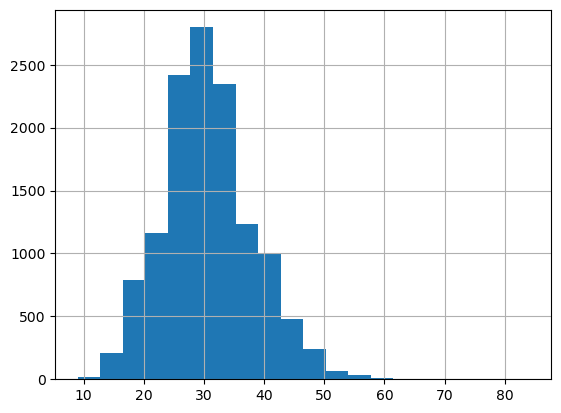

In [12]:
tab['SOG_home'].hist(bins=20)

### Эло

In [197]:
t = tab.copy()

t.sample(5)

,id_season,id_match,id_regular,start_time,location,viewers,coach_home,coach_away,referee_1,referee_2,linesman_1,linesman_2,team_home,team_away,G_home,G_away,end_match,G_home_1per,G_away_1per,G_home_2per,G_away_2per,G_home_3per,G_away_3per,G_home_OT,G_away_OT,G_home_SO,G_away_SO,G_home_RT,G_away_RT,G_home_5on5,G_home_5on4,G_home_5on3,G_home_4on4,G_home_4on3,G_home_3on3,G_home_3on4,G_home_3on5,G_home_4on5,G_home_EN,G_home_bul,G_away_5on5,G_away_5on4,G_away_5on3,G_away_4on4,G_away_4on3,G_away_3on3,G_away_3on4,G_away_3on5,G_away_4on5,G_away_EN,G_away_bul,SOG_home,SOG_away,SOG_home_1per,SOG_away_1per,SOG_home_2per,SOG_away_2per,SOG_home_3per,SOG_away_3per,SOG_home_OT,SOG_away_OT,SOG_home_RT,SOG_away_RT,BLK_home,BLK_away,BLK_home_1per,BLK_away_1per,BLK_home_2per,BLK_away_2per,BLK_home_3per,BLK_away_3per,BLK_home_OT,BLK_away_OT,BLK_home_RT,BLK_away_RT,HIT_home,HIT_away,HIT_home_1per,HIT_away_1per,HIT_home_2per,HIT_away_2per,HIT_home_3per,HIT_away_3per,HIT_home_OT,HIT_away_OT,HIT_home_RT,HIT_away_RT,attack_time_home,attack_time_away,attack_time_home_1per,attack_time_away_1per,attack_time_home_2per,attack_time_away_2per,attack_time_home_3per,attack_time_away_3per,attack_time_home_OT,attack_time_away_OT,attack_time_home_RT,attack_time_away_RT,control_time_home,control_time_away,control_time_home_1per,control_time_away_1per,control_time_home_2per,control_time_away_2per,control_time_home_3per,control_time_away_3per,control_time_home_OT,control_time_away_OT,control_time_home_RT,control_time_away_RT,distance_covered_home,distance_covered_away,distance_covered_home_1per,distance_covered_away_1per,distance_covered_home_2per,distance_covered_away_2per,distance_covered_home_3per,distance_covered_away_3per,distance_covered_home_OT,distance_covered_away_OT,distance_covered_home_RT,distance_covered_away_RT,season,is_playoff,day,num_day
9591,19-20_RS,82421,634,2020-01-30 17:00:00,ЛА «Трактор» им. В. Белоусова,5890,Юрзинов Владимир,Фрейзер Курт,Сергеев Александр В,Щенёв Роман,Горденко Константин,Захаров Даниил,TRK,KRS,3,1,RT,1,0,0,0,2,1,NaN,NaN,NaN,NaN,3,1,3,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,37,29,10,7,12,10,15,12,37,29,37,29,9.0,13.0,3.0,5.0,3.0,2.0,3.0,6.0,9.0,13.0,9.0,13.0,12.0,8.0,4.0,3.0,4.0,5.0,4.0,0.0,12.0,8.0,12.0,8.0,787.0,588.0,220.0,211.0,261.0,183.0,306.0,194.0,787.0,588.0,787.0,588.0,1288.0,939.0,397.0,331.0,426.0,281.0,465.0,326.0,1288.0,939.0,1288.0,938.0,71.81,72.48,23.81,24.56,24.84,24.34,23.17,23.58,71.81,72.48,71.82,72.48,20,0,2020-01-30,131
2280,11-12_RS,31006,98,2011-10-04 20:00:00,МКСК «Минск-Арена»,12330,Марек Сикора,Ханну Йортикка,Яков Деев,Александр Соин,Михаил Калинкин,Степан Капустин,DMN,AMR,5,3,RT,0,1,2,1,3,1,NaN,NaN,NaN,NaN,5,3,3,2,0,0,0,0,0,0,0,1,0,1,0,2,0,0,0,0,0,0,0,0,41,27,15,14,10,5,16,8,41,27,41,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,0,2011-10-04,22
8442,18-19_RS,70820,341,2018-11-15 19:00:00,ЛДС «Татнефть Арена»,8890,Билялетдинов Зинэтула,Никитин Игорь,Раводин Алексей,Гусев Сергей,Голяк Дмитрий,Дедюля Иван,AKB,CSKA,0,5,RT,0,1,0,3,0,1,NaN,NaN,NaN,NaN,0,5,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,1,0,0,24,28,4,9,10,10,10,9,24,28,24,28,12.0,8.0,8.0,2.0,3.0,4.0,1.0,2.0,12.0,8.0,12.0,8.0,33.0,9.0,15.0,4.0,12.0,3.0,6.0,2.0,33.0,9.0,33.0,9.0,614.0,666.0,87.0,265.0,246.0,260.0,281.0,141.0,614.0,666.0,614.0,666.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,0,2018-11-15,70
9644,19-20_RS,82475,688,2020-02-15 17:00:00,ЛД «Нефтехим Арена»,4211,Буцаев Вячеслав,Светлов Сергей,Белов Алексей,Гофман Антон,Берсенёв Максим,Сысуев Александр,NKH,ADM,6,1,RT,2,0,2,0,2,1,NaN,NaN,NaN,NaN,6,1,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,40,15,14,3,9,2,17,10,40,15,40,15,12.0,14.0,7.0,6.0,2.0,5.0,3.0,3.0,12.0,14.0,12.0,14.0,7.0,12.0,3.0,3.0,3.0,3.0,1.0,6.0,7.0,12.0,7.0,12.0,712.0,58

In [198]:
t.isna().sum()

id_season                         0
id_match                          0
id_regular                        0
start_time                        0
location                          0
viewers                           0
coach_home                        0
coach_away                        0
referee_1                        19
referee_2                      1159
linesman_1                        0
linesman_2                        1
team_home                         0
team_away                         0
G_home                            0
G_away                            0
end_match                         0
G_home_1per                       0
G_away_1per                       0
G_home_2per                       0
G_away_2per                       0
G_home_3per                       0
G_away_3per                       0
G_home_OT                      9938
G_away_OT                      9938
G_home_SO                     11427
G_away_SO                     11427
G_home_RT                   

In [199]:
t[t['G_away'].isna()]

,id_season,id_match,id_regular,start_time,location,viewers,coach_home,coach_away,referee_1,referee_2,linesman_1,linesman_2,team_home,team_away,G_home,G_away,end_match,G_home_1per,G_away_1per,G_home_2per,G_away_2per,G_home_3per,G_away_3per,G_home_OT,G_away_OT,G_home_SO,G_away_SO,G_home_RT,G_away_RT,G_home_5on5,G_home_5on4,G_home_5on3,G_home_4on4,G_home_4on3,G_home_3on3,G_home_3on4,G_home_3on5,G_home_4on5,G_home_EN,G_home_bul,G_away_5on5,G_away_5on4,G_away_5on3,G_away_4on4,G_away_4on3,G_away_3on3,G_away_3on4,G_away_3on5,G_away_4on5,G_away_EN,G_away_bul,SOG_home,SOG_away,SOG_home_1per,SOG_away_1per,SOG_home_2per,SOG_away_2per,SOG_home_3per,SOG_away_3per,SOG_home_OT,SOG_away_OT,SOG_home_RT,SOG_away_RT,BLK_home,BLK_away,BLK_home_1per,BLK_away_1per,BLK_home_2per,BLK_away_2per,BLK_home_3per,BLK_away_3per,BLK_home_OT,BLK_away_OT,BLK_home_RT,BLK_away_RT,HIT_home,HIT_away,HIT_home_1per,HIT_away_1per,HIT_home_2per,HIT_away_2per,HIT_home_3per,HIT_away_3per,HIT_home_OT,HIT_away_OT,HIT_home_RT,HIT_away_RT,attack_time_home,attack_time_away,attack_time_home_1per,attack_time_away_1per,attack_time_home_2per,attack_time_away_2per,attack_time_home_3per,attack_time_away_3per,attack_time_home_OT,attack_time_away_OT,attack_time_home_RT,attack_time_away_RT,control_time_home,control_time_away,control_time_home_1per,control_time_away_1per,control_time_home_2per,control_time_away_2per,control_time_home_3per,control_time_away_3per,control_time_home_OT,control_time_away_OT,control_time_home_RT,control_time_away_RT,distance_covered_home,distance_covered_away,distance_covered_home_1per,distance_covered_away_1per,distance_covered_home_2per,distance_covered_away_2per,distance_covered_home_3per,distance_covered_away_3per,distance_covered_home_OT,distance_covered_away_OT,distance_covered_home_RT,distance_covered_away_RT,season,is_playoff,day,num_day


In [200]:
'''функция расчета рейтинга Эло в матче'''

def elo_rating(row):
    '''получаем значения рейтинга для команд из словаря'''
    R_H = team_elo_dict.get(row['team_home'])
    R_A = team_elo_dict.get(row['team_away'])
    
    '''эти значения сразу записываем как данные по матчу'''
    row['elo_home'] = R_H
    row['elo_away'] = R_A
    row['elo_mean_league'] = pd.Series([team_elo_dict[k] for k in team_elo_dict]).mean()
    
    '''если матч плей офф, то тогда делаем поправку для разницы рейтингов между командами,
    исходя из предположений, что в важных матчах фаворит усиливает свое премущество.
    Домашняя команда по-умолчанию получает +50 к рейтингу Эло''' 
    if row['is_playoff'] == 1:
        EloDf = (R_H + 50 - R_A) * 1.25
    else:
        EloDf = R_H + 50 - R_A
        
    '''Делаем расчет рейтинга по результату матча для обоих команд
    K - кф используйщийся в ретинге Эло. Подбирается эксперементально. Для хоккея оптимально 6
    H - множитель, учитывающий разницу голов в матче
    PF - множитель, учитывающий предматчевый вероятности победы команд
    AC - множитель, уменьшающий, набор очков в матчах, где побеждает команда с бОльшим рейтингом Эло
    shift - изменение рейтинга Эло по результату матча. Прибавится к рейтингу победителя и вычтится у проигравшего'''
    if row['G_home'] > row['G_away']:
        p_H = 1 / (10 ** ((-EloDf) / 400) + 1)
        K = 6
        H = 0.6686 * np.log(row['G_home'] - row['G_away']) + 0.8048
        PF = 1 - p_H
        if R_H > R_A:
            AC = 2.05 / ((R_H - R_A) * 0.001 + 2.05)
        else:
            AC = 1
        shift = K * H * PF * AC
        team_elo_dict.update({row['team_home']: R_H + shift, row['team_away']: R_A - shift})
    else:
        p_A = 1 / (10 ** ((EloDf) / 400) + 1)
        K = 6
        H = 0.6686 * np.log(row['G_away'] - row['G_home']) + 0.8048
        PF = 1 - p_A
        if R_A > R_H:
            AC = 2.05 / ((R_A - R_H) * 0.001 + 2.05)
        else:
            AC = 1
        shift = K * H * PF * AC
        '''лбновляем данные по рейтингам в словаре'''
        team_elo_dict.update({row['team_home']: R_H - shift, row['team_away']: R_A + shift})
#     print(f"{row['team_home']} против {row['team_away']} Elo:{R_H:0.1f}-{R_A:0.1f}, счет матча: {row['G_home']}-{row['G_away']}, изменение Elo:{shift:0.1f}")    
    return row

In [201]:
'''функция поправки рейтингов к среднему перед началом нового сезона'''

def rating_adjustment(team_elo_dict):
    mean_rating = pd.Series([team_elo_dict[k] for k in team_elo_dict]).mean()
    for k, v in team_elo_dict.items():
        team_elo_dict[k] = v * 0.9 + mean_rating * 0.1
    return team_elo_dict

Последовательность действий для расчета рейтинга:
- создать начальный словарь с рейтингами эло для команд первого сезона
- просчитать рейтинги за весь первый сезон
- пометить текущий набор команд как прошлогодный
- сделать корректировку рейтингов к среднему по лиге
- определить есть ли новые команды в лиге
- присвоить значения рейтинга для новых команд
- просчитать рейтинги за весь второй сезон и так далее...

In [202]:
first_season_team = t[t['season'] == 9]['team_home']
team_elo_dict = dict(zip(first_season_team.unique(), [1500] * len(first_season_team.unique())))
previous_season = set(first_season_team.unique())

In [203]:
first_season_team = t[t['season'] == 9]['team_home']
team_elo_dict = dict(zip(first_season_team.unique(), [1500] * len(first_season_team.unique())))
previous_season = set(first_season_team.unique())
df = t[t['season'] == 9].apply(elo_rating, axis=1, result_type='expand')
for s in t['season'].unique():
    season = t[t['season'] == s]
    team_set = set(season['team_home'].unique())
    if s > 9:
        team_elo_dict = rating_adjustment(team_elo_dict)
        new_team = team_set - previous_season
        if len(new_team) > 0:
            team_elo_dict.update(zip(new_team, [1450] * len(new_team)))
        new_season = season.apply(elo_rating, axis=1, result_type='expand')
        df = pd.concat([df, new_season])
        
    new_team = team_set - previous_season
    if len(new_team) > 0:
        team_elo_dict.update(zip(new_team, [1450] * len(new_team)))

    previous_season = team_set

In [204]:
team_elo_dict

{'SAL': 1566.7924672590013,
 'AMR': 1451.687294095696,
 'MNK': 1398.3366841315412,
 'SPR': 1524.8393482153556,
 'VIT': 1385.7181173899314,
 'TOR': 1513.3252381380094,
 'SIB': 1466.704540905124,
 'MMG': 1576.2958224853508,
 'TRK': 1526.1279215566205,
 'AKB': 1566.2937307634486,
 'NKH': 1427.6856169956498,
 'LAD': 1450,
 'ATL': 1479.884541486318,
 'MVD': 1495.0751586252425,
 'CSKA': 1562.3468927265756,
 'AVG': 1567.225663890938,
 'BAR': 1396.097044566184,
 'SKA': 1628.009683089849,
 'SEV': 1495.87201104341,
 'DRG': 1361.0335917407592,
 'LOK': 1593.790813629654,
 'DMN': 1470.2147329909792,
 'HIM': 1467.7970371741055,
 'DYN': 1573.052113727994,
 'AVT': 1541.4911770257227,
 'UGR': 1418.0353947027797,
 'LEV': 1504.1708784943476,
 'SLV': 1399.2420681635901,
 'DON': 1490.2671032059154,
 'MDV': 1441.1995066414502,
 'ADM': 1429.1697658280737,
 'YOK': 1534.7658126617941,
 'SCH': 1343.9640225173914,
 'KRS': 1364.8594688451224}

### Выделение признаков

In [263]:
data = df[['SOG_home_RT', 'SOG_away_RT', 'season', 'num_day', 'start_time',\
           'team_home', 'team_away', 'G_home_RT', 'G_away_RT', 'elo_home', 'elo_away', 'is_playoff']].copy()
data['elo_home_diff_mean'] = df['elo_home'] - df['elo_mean_league']
data['elo_away_diff_mean'] = df['elo_away'] - df['elo_mean_league']

In [219]:
def get_team_stats(df):
    home_games = df[['SOG_home_RT', 'SOG_away_RT', 'season', 'num_day', 'start_time',\
           'team_home', 'team_away', 'G_home_RT', 'G_away_RT', 'elo_home',\
                     'elo_away', 'is_playoff', 'elo_home_diff_mean', 'elo_away_diff_mean']].copy()
    home_games['loc_first_team'] = 'H'
    home_games.columns = ['SOG_1', 'SOG_2', 'season', 'num_day', 'start_time',
              'team_1', 'team_2', 'G_1', 'G_2', 'elo_1', 'elo_2', 'is_playoff', 
                         'elo_1_diff_mean', 'elo_2_diff_mean', 'loc_first_team']
    
    away_games = df[['SOG_away_RT', 'SOG_home_RT', 'season', 'num_day', 'start_time',\
            'team_away', 'team_home', 'G_away_RT', 'G_home_RT', 'elo_away',\
                     'elo_home', 'is_playoff', 'elo_away_diff_mean', 'elo_home_diff_mean']].copy()
    away_games['loc_first_team'] = 'A'
    away_games.columns = ['SOG_1', 'SOG_2', 'season', 'num_day', 'start_time',
              'team_1', 'team_2', 'G_1', 'G_2', 'elo_1', 'elo_2', 'is_playoff', 
                         'elo_1_diff_mean', 'elo_2_diff_mean', 'loc_first_team']
    
    team_stats = pd.concat([home_games, away_games])
    team_stats = team_stats.sort_values('start_time')
    return team_stats

In [264]:
team_stats = get_team_stats(data)

Какие данные должны быть:
- броски хозяева (таргет!!!)
- броски гости (таргет!!!)
- номер сезона
- номер игрового дня
- хозяева
- гости
- Эло хозяев
- Эло гостей
- это плей офф?
- Эло хозяев - средний Эло
- Эло гостей - средний Эло
- -------------------------------------------------------------
- ср. кол-во шайб в основное время хозяев в последних n матчах
- ср. кол-во пропущенных шайб в основное время хозяев в последних n матчах
- средний рейтинг Эло хозяев за последние n матчей
- средний рейтинг Эло соперников хозяев за последние n матчей
- ср. кол-во бросков хозяев в последних n матчах
- ср. кол-во пропущенных бросков хозяев в последних n матчах
- доля матчей плей офф для хозяев в последних n матчах
- -------------------------------------------------------------
- ср. кол-во шайб в основное время хозяев дома в последних n матчах
- ср. кол-во пропущенных шайб в основное время хозяев дома в последних n матчах
- ср. кол-во бросков хозяев дома в последних n матчах
- ср. кол-во пропущенных бросков хозяев дома в последних n матчах
- доля матчей плей офф для хозяев дома в последних n матчах
- --------------------------------------------------------------
- ср. кол-во шайб в основное время гостей в последних n матчах
- ср. кол-во шайб в основное время соперника гостей в последних n матчах
- средний рейтинг Эло гостей за последние n матчей
- средний рейтинг Эло соперников гостей за последние n матчей
- ср. кол-во бросков гостей в последних n матчах
- ср. кол-во бросков соперника гостей в последних n матчах
- доля матчей плей офф для гостей в последних n матчах
- --------------------------------------------------------------
- ср. кол-во шайб в основное время гостей на выезде в последних n матчах
- ср. кол-во шайб в основное время соперника гостей на выезде в последних n матчах
- ср. кол-во бросков гостей на выезде в последних n матчах
- ср. кол-во бросков соперника гостей на выезде в последних n матчах
- доля матчей плей офф для гостей на выезде в последних n матчах

In [221]:
def rolling_averages(group, cols, new_cols5, new_cols10, new_cols15):
    group = group.sort_values('start_time')
    rolling_stats_5 = group[cols].rolling(5, closed='left').mean()
    rolling_stats_10 = group[cols].rolling(10, closed='left').mean()
    rolling_stats_15 = group[cols].rolling(15, closed='left').mean()
#     rolling_stats_30 = group[cols].rolling(30, closed='left').mean()
    group[new_cols5] = rolling_stats_5
    group[new_cols10] = rolling_stats_10
    group[new_cols15] = rolling_stats_15
#     group[new_cols30] = rolling_stats_30
    group = group.dropna(subset=[*new_cols5, *new_cols10, *new_cols15])
    return group

In [222]:
cols_t1 = ['G_1', 'G_2', 'elo_1', 'elo_2', 'SOG_1', 'SOG_2', 'is_playoff']
cols_t1_home = ['G_1', 'G_2', 'SOG_1', 'SOG_2', 'is_playoff']
cols_t2 = ['G_2', 'G_1', 'elo_2', 'elo_1', 'SOG_2', 'SOG_1', 'is_playoff']
cols_t2_away = ['G_2', 'G_1', 'SOG_2', 'SOG_1', 'is_playoff']
cols = ['GF', 'GA', 'eloF', 'eloA', 'SOGF', 'SOGA', 'is_playoff']
cols_loc = ['GF', 'GA', 'SOGF', 'SOGA', 'is_playoff']
new_cols5_t1 = [f"{c}_t1_roll_5" for c in cols]
new_cols10_t1 = [f"{c}_t1_roll_10" for c in cols]
new_cols15_t1 = [f"{c}_t1_roll_15" for c in cols]
# new_cols30_t1 = [f"{c}_t1_roll_30" for c in cols]
new_cols5_t1_home = [f"{c}_t1_roll_5_home" for c in cols_loc]
new_cols10_t1_home = [f"{c}_t1_roll_10_home" for c in cols_loc]
new_cols15_t1_home = [f"{c}_t1_roll_15_home" for c in cols_loc]
# new_cols30_t1_home = [f"{c}_t1_roll_30_home" for c in cols_loc]
new_cols5_t2 = [f"{c}_t2_roll_5" for c in cols]
new_cols10_t2 = [f"{c}_t2_roll_10" for c in cols]
new_cols15_t2 = [f"{c}_t2_roll_15" for c in cols]
# new_cols30_t2 = [f"{c}_t2_roll_30" for c in cols]
new_cols5_t2_away = [f"{c}_t2_roll_5_away" for c in cols_loc]
new_cols10_t2_away = [f"{c}_t2_roll_10_away" for c in cols_loc]
new_cols15_t2_away = [f"{c}_t2_roll_15_away" for c in cols_loc]
# new_cols30_t2_away = [f"{c}_t2_roll_30_away" for c in cols_loc]

In [223]:
matches_rolling_t1 = team_stats.groupby('team_1').apply(
    lambda x: rolling_averages(x, cols_t1, new_cols5_t1, new_cols10_t1, new_cols15_t1))

matches_rolling_t1 = matches_rolling_t1.droplevel('team_1')

In [224]:
matches_rolling_t1_home = team_stats[team_stats['loc_first_team'] == 'H'].groupby('team_1').apply(
    lambda x: rolling_averages(x, cols_t1_home, new_cols5_t1_home, new_cols10_t1_home, 
                               new_cols15_t1_home))

matches_rolling_t1_home = matches_rolling_t1_home.droplevel('team_1')

In [225]:
matches_rolling_t2 = team_stats.groupby('team_2').apply(
    lambda x: rolling_averages(x, cols_t2, new_cols5_t2, new_cols10_t2, new_cols15_t2))

matches_rolling_t2 = matches_rolling_t2.droplevel('team_2')

In [226]:
matches_rolling_t2_away = team_stats[team_stats['loc_first_team'] == 'H'].groupby('team_2').apply(
    lambda x: rolling_averages(x, cols_t2_away, new_cols5_t2_away, new_cols10_t2_away, 
                               new_cols15_t2_away))

matches_rolling_t2_away = matches_rolling_t2_away.droplevel('team_2')

In [227]:
matches_rolling_t = pd.merge(matches_rolling_t1, matches_rolling_t2, on=team_stats.columns.to_list())

In [228]:
matches_rolling_t_loc = pd.merge(matches_rolling_t1_home, matches_rolling_t2_away, on=team_stats.columns.to_list())

In [229]:
matches_rolling_t = matches_rolling_t.sort_values('start_time')
matches_rolling_t_loc = matches_rolling_t_loc.sort_values('start_time').reset_index(drop=True)
matches_rolling_t = matches_rolling_t[matches_rolling_t['loc_first_team'] == 'H'].reset_index(drop=True)

In [230]:
matches_rolling = pd.merge(matches_rolling_t, matches_rolling_t_loc, on=team_stats.columns.to_list())

In [231]:
matches_rolling = matches_rolling.sort_values('start_time').reset_index(drop=True)

In [232]:
matches_rolling.tail(15)

,SOG_1,SOG_2,season,num_day,start_time,team_1,team_2,G_1,G_2,elo_1,elo_2,is_playoff,elo_1_diff_mean,elo_2_diff_mean,loc_first_team,GF_t1_roll_5,GA_t1_roll_5,eloF_t1_roll_5,eloA_t1_roll_5,SOGF_t1_roll_5,SOGA_t1_roll_5,is_playoff_t1_roll_5,GF_t1_roll_10,GA_t1_roll_10,eloF_t1_roll_10,eloA_t1_roll_10,SOGF_t1_roll_10,SOGA_t1_roll_10,is_playoff_t1_roll_10,GF_t1_roll_15,GA_t1_roll_15,eloF_t1_roll_15,eloA_t1_roll_15,SOGF_t1_roll_15,SOGA_t1_roll_15,is_playoff_t1_roll_15,GF_t2_roll_5,GA_t2_roll_5,eloF_t2_roll_5,eloA_t2_roll_5,SOGF_t2_roll_5,SOGA_t2_roll_5,is_playoff_t2_roll_5,GF_t2_roll_10,GA_t2_roll_10,eloF_t2_roll_10,eloA_t2_roll_10,SOGF_t2_roll_10,SOGA_t2_roll_10,is_playoff_t2_roll_10,GF_t2_roll_15,GA_t2_roll_15,eloF_t2_roll_15,eloA_t2_roll_15,SOGF_t2_roll_15,SOGA_t2_roll_15,is_playoff_t2_roll_15,GF_t1_roll_5_home,GA_t1_roll_5_home,SOGF_t1_roll_5_home,SOGA_t1_roll_5_home,is_playoff_t1_roll_5_home,GF_t1_roll_10_home,GA_t1_roll_10_home,SOGF_t1_roll_10_home,SOGA_t1_roll_10_home,is_playoff_t1_roll_10_home,GF_t1_roll_15_home,GA_t1_roll_15_home,SOGF_t1_roll_15_home,SOGA_t1_roll_15_home,is_playoff_t1_roll_15_home,GF_t2_roll_5_away,GA_t2_roll_5_away,SOGF_t2_roll_5_away,SOGA_t2_roll_5_away,is_playoff_t2_roll_5_away,GF_t2_roll_10_away,GA_t2_roll_10_away,SOGF_t2_roll_10_away,SOGA_t2_roll_10_away,is_playoff_t2_roll_10_away,GF_t2_roll_15_away,GA_t2_roll_15_away,SOGF_t2_roll_15_away,SOGA_t2_roll_15_away,is_playoff_t2_roll_15_away
12135,39,25,24,187,2024-04-02 19:30:00,LOK,TRK,5,2,1593.881608,1536.761484,1,110.955873,53.835748,H,2.0,1.8,1593.767922,1567.339349,29.6,20.2,1.0,2.8,1.6,1588.755267,1568.804803,28.6,22.0,1.0,2.400000,1.800000,1586.524586,1556.227333,30.333333,22.200000,0.800000,4.0,2.8,1527.694004,1578.218316,22.0,37.6,1.0,3.1,2.6,1522.483713,1575.626052,23.1,37.3,1.0,2.866667,2.600000,1519.278461,1535.553552,27.333333,34.133333,0.666667,2.8,1.8,32.4,21.6,1.0,2.3,2.4,34.0,22.6,0.6,2.333333,2.400000,34.666667,22.533333,0.400000,2.8,2.6,23.6,37.2,1.0,2.4,3.2,28.6,36.9,0.5,2.600000,3.400000,28.866667,35.600000,0.333333
12136,35,32,24,188,2024-04-03 17:00:00,MMG,AVT,2,1,1567.883870,1539.178773,1,84.958135,56.253038,H,2.2,1.8,1563.706363,1529.016855,28.4,37.2,1.0,2.5,1.9,1562.411925,1498.603497,30.9,35.4,1.0,2.466667,1.666667,1562.242063,1486.756091,33.466667,33.066667,0.800000,2.8,2.6,1533.950624,1633.237833,32.4,33.8,1.0,2.5,2.1,1528.469282,1601.875650,32.2,31.9,1.0,2.600000,1.933333,1521.984995,1567.554163,31.400000,28.866667,0.666667,3.0,1.4,33.8,32.6,1.0,2.7,1.1,35.4,31.3,0.6,3.066667,1.466667,35.800000,31.466667,0.400000,3.4,1.6,33.4,34.6,1.0,3.2,2.3,31.2,33.3,0.6,2.733333,2.133333,30.733333,31.266667,0.400000
12137,29,24,24,189,2024-04-04 19:30:00,LOK,TRK,2,2,1596.723832,1533.919260,1,113.798096,50.993524,H,2.8,2.0,1593.218144,1561.796291,30.6,21.8,1.0,3.1,1.6,1590.348834,1565.347219,29.9,22.0,1.0,2.466667,1.800000,1587.411089,1553.454577,30.600000,21.733333,0.866667,3.6,3.4,1531.106792,1582.872704,21.2,36.6,1.0,3.0,2.9,1524.574931,1577.568422,22.9,37.8,1.0,2.800000,2.800000,1520.830927,1546.479097,26.866667,34.000000,0.733333,3.4,2.0,33.4,23.6,1.0,2.7,2.4,33.7,23.4,0.7,2.533333,2.400000,35.066667,22.733333,0.466667,2.6,3.2,23.2,38.2,1.0,2.5,3.5,28.1,37.9,0.6,2.533333,3.466667,28.600000,36.266667,0.400000
12138,24,21,24,190,2024-04-05 17:00:00,MMG,AVT,2,4,1569.608159,1537.454484,1,86.682424,54.528749,H,2.4,2.0,1564.195721,1531.395382,29.6,37.0,1.0,2.4,1.8,1563.001799,1507.374514,30.8,34.7,1.0,2.400000,1.733333,1562.922450,1492.371815,33.133333,33.266667,0.866667,2.4,2.6,1536.344843,1618.818451,33.6,34.4,1.0,2.4,2.2,1530.809615,1600.891440,32.9,32.3,1.0,2.400000,1.933333,1524.236559,1566.825558,31.933333,29.733333,0.733333,3.0,1.0,31.4,34.8,1.0,2.7,1.1,35.0,31.6,0.7,2.866667,1.400000,35.933333,31.800000,0.466667,2.8,2.0,33.2,34.8,1.0,2.9,2.1,31.7,32.4,0.7,2.733333,2.133333,31.133333,31.400000,0.466667
12139,30,28,24,191,2024-04-06 14:30:00,TRK,LOK,1,2,1532.478403,1598.164688,1,49.552668,115.238953,H,3.2,3.4,1533.187695,1584.957700,22.2,

### Обучение модели

In [233]:
X = matches_rolling.drop(['SOG_1', 'SOG_2', 'start_time', 'G_1', 'G_2', 'loc_first_team'], axis=1)
y = matches_rolling[['SOG_1', 'SOG_2']]


In [234]:
cat_features = ['team_1', 'team_2']

In [235]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1009)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5, random_state=1009)

In [236]:
params = {'cat_features': cat_features,
          'random_state': 1009,
          "loss_function": "MultiRMSE",
          'verbose': 100}

In [237]:
model = CatBoostRegressor(**params)

In [238]:
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

0:	learn: 10.0810092	test: 10.1050627	best: 10.1050627 (0)	total: 60.5ms	remaining: 1m
100:	learn: 8.9082234	test: 9.2237540	best: 9.2237540 (100)	total: 8.3s	remaining: 1m 13s
200:	learn: 8.7224017	test: 9.1731632	best: 9.1731632 (200)	total: 15s	remaining: 59.6s
300:	learn: 8.6039711	test: 9.1602637	best: 9.1602637 (300)	total: 23.5s	remaining: 54.6s
400:	learn: 8.4888717	test: 9.1568147	best: 9.1556625 (365)	total: 30.3s	remaining: 45.3s
500:	learn: 8.3752666	test: 9.1571369	best: 9.1556625 (365)	total: 38.3s	remaining: 38.1s
600:	learn: 8.2690749	test: 9.1567587	best: 9.1549168 (530)	total: 45.3s	remaining: 30.1s
700:	learn: 8.1671901	test: 9.1590254	best: 9.1549168 (530)	total: 53.4s	remaining: 22.8s
800:	learn: 8.0695163	test: 9.1622602	best: 9.1549168 (530)	total: 1m 1s	remaining: 15.2s
900:	learn: 7.9660630	test: 9.1622200	best: 9.1549168 (530)	total: 1m 9s	remaining: 7.62s
999:	learn: 7.8688548	test: 9.1623247	best: 9.1549168 (530)	total: 1m 16s	remaining: 0us

bestTest = 9.15

In [239]:
pickle.dump(model, open('shot_model', 'wb'))

In [240]:
y_pred = model .predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['SOG_1_pred', 'SOG_2_pred'], index=X_test.index)
y_pred

,SOG_1_pred,SOG_2_pred
1605,28.094436,26.874239
4203,29.410655,30.083149
8481,26.470351,26.884498
1364,28.961240,26.406698
1375,32.153011,29.863949
...,...,...
1480,26.265197,28.622944
4166,35.370052,27.983023
6293,30.600587,34.738621
3978,29.530207,29.108870


In [241]:
y_test

,SOG_1,SOG_2
1605,28,18
4203,26,28
8481,22,23
1364,30,21
1375,30,28
...,...,...
1480,30,35
4166,38,29
6293,27,26
3978,25,33


In [242]:
mean_squared_error(y_test , y_pred, squared=False)

6.5540072838541095

In [243]:
predict = pd.DataFrame(model.predict(X_test), index=y_pred.index)

In [244]:
result = pd.merge(y_pred, y_test, left_index=True, right_index=True).reset_index(drop=True)

<AxesSubplot:>

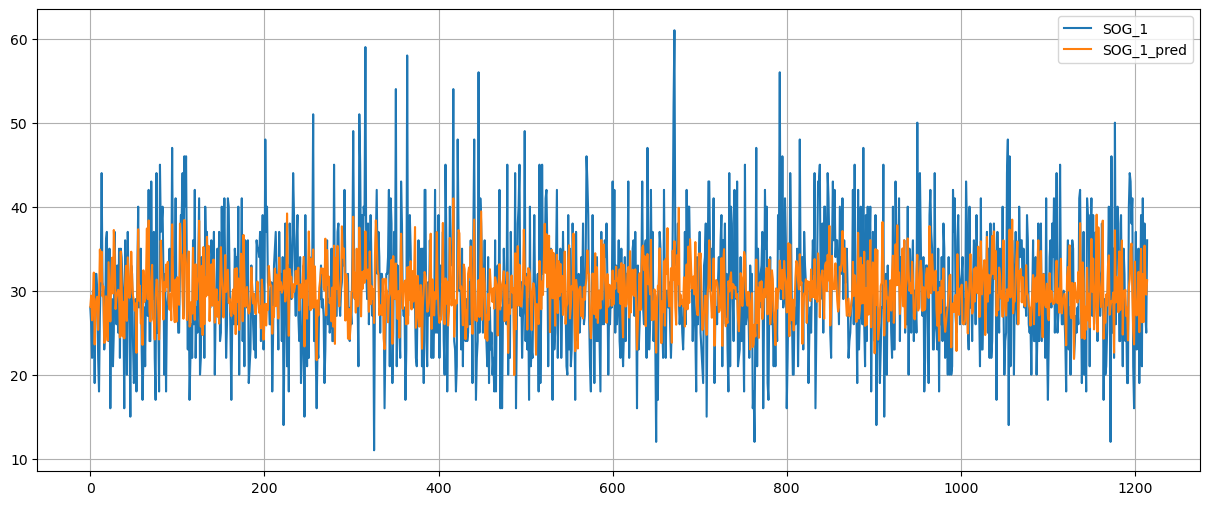

In [245]:
result[['SOG_1', 'SOG_1_pred']].plot(figsize=(15,6), grid=True)

<AxesSubplot:>

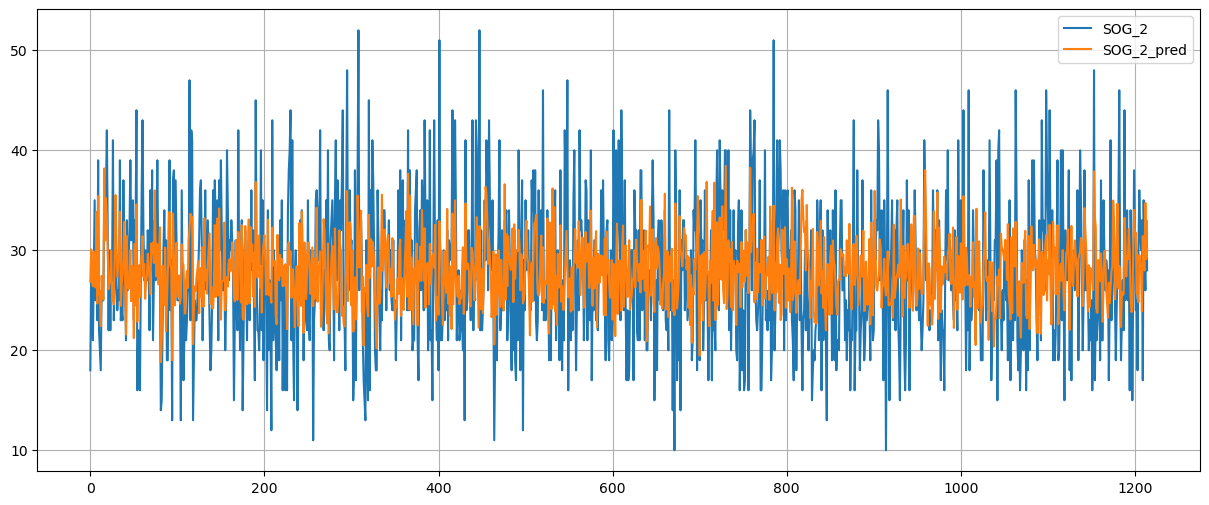

In [246]:
result[['SOG_2', 'SOG_2_pred']].plot(figsize=(15,6), grid=True)

In [247]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,SOGA_t1_roll_15_home,5.390361
1,SOGA_t2_roll_15,5.248431
2,team_1,4.427723
3,SOGF_t1_roll_15_home,4.136714
4,SOGA_t1_roll_15,4.053301
5,team_2,3.732073
6,SOGA_t1_roll_10_home,3.519160
7,SOGF_t1_roll_15,3.188410
8,SOGA_t1_roll_10,2.693794
9,SOGF_t1_roll_10_home,2.671434


### Предикт для новых данных

In [174]:
new = pd.read_csv('feature_match.csv')

In [248]:
test_data = {
    'id_season': ['23-24_PO'],
    'id_regular': [90],
    'team_home': ['LOK'],
    'team_away': ['MMG'],
    'start_time': ['17.06.2024 19:00']
}

new = pd.DataFrame(test_data)

In [249]:
new

,id_season,id_regular,team_home,team_away,start_time
0,23-24_PO,90,LOK,MMG,17.06.2024 19:00


In [250]:
# ренейминг команд на краткие аббривиатуры
for col in ['team_home', 'team_away']:
    new = new.replace({col:t_dic})

In [251]:
# оставляем матчи только с аббривиатурами команд КХЛ, убирая из данных матчи всех звезд
new = new[new['team_home'].isin(team_name_dict.values())]
new = new[new['team_away'].isin(team_name_dict.values())].reset_index(drop=True)

In [170]:
m = {
    'января': '01',
    'февраля': '02',
    'марта': '03',
    'апреля': '04',
    'мая': '05',
    'июня': '06',
    'июля': '07',
    'августа': '08',
    'сентября': '09',
    'октября': '10',
    'ноября': '11',
    'декабря': '12'
}

In [171]:
def date_processing(row):
    num_date = row['start_time'].split(' ')[0]
    num_month = row['start_time'].split(' ')[1]
    num_month = num_month.replace(num_month, m[num_month])
    num_year = row['start_time'].split(' ')[2]
    msk_time = row['start_time'].split(' ')[3]
    row['start_time'] = num_date + '.' + num_month + '.' + num_year + ' ' + msk_time
    return row

In [173]:
new = new.apply(date_processing, axis=1)

KeyError: '17:00:00'

In [252]:
# создаем колонку с номером сезона
new['season'] = new['id_season'].apply(lambda x: int(x[3:5]))
# создаем булеву колонку с указанием для матчей плей офф
new['is_playoff'] = new['id_season'].apply(lambda x: 1 if x[6:8] == 'PO' else 0)
# изменяем на временной тип данных для времени начала матча
new['start_time'] = pd.to_datetime(new['start_time'], format='%d.%m.%Y %H:%M')
# добавляем колонку с датой начала матча
new['day'] = new['start_time'].dt.date

In [253]:
new

,id_season,id_regular,team_home,team_away,start_time,season,is_playoff,day
0,23-24_PO,90,LOK,MMG,2024-06-17 19:00:00,24,1,2024-06-17


In [254]:
d = tab[tab['id_season'] == new.loc[0]['id_season']][new.columns]

In [255]:
d = pd.concat([d, new])

In [256]:
# добавляем колонку с нумерацией игрового дня
d['num_day'] = d[['season', 'day']].groupby('season').rank(method='dense').astype(int)

In [257]:
new = d[d.index.isin(new.index)].copy()

In [258]:
new['elo_mean_league'] = df.iloc[-1, -1]

In [259]:
new = new.drop(['id_season', 'id_regular', 'day'], axis=1)

In [260]:
new

,team_home,team_away,start_time,season,is_playoff,num_day,elo_mean_league
0,LOK,MMG,2024-06-17 19:00:00,24,1,41,1482.925735


In [261]:
def get_new_feature(new, data, day='td'):
    if day == 'td':
        new = new[new['start_time'].dt.date == datetime.date.today()].copy()
    elif day == 'tm':
        new = new[new['start_time'].dt.date == datetime.date.today() + datetime.timedelta(days=1)].copy()
    new[['SOG_home_RT', 'SOG_away_RT', 'G_home_RT', 'G_away_RT']] = 0
    new['elo_home'] = new['team_home'].apply(lambda x: team_elo_dict.get(x))
    new['elo_away'] = new['team_away'].apply(lambda x: team_elo_dict.get(x))
    new['elo_home_diff_mean'] = new['elo_home'] - new['elo_mean_league']
    new['elo_away_diff_mean'] = new['elo_away'] - new['elo_mean_league']
    new = new.drop(['elo_mean_league'], axis=1)
    new_rolling = pd.concat([data.tail(1000), new])
    team_stats = get_team_stats(new_rolling)
    
    matches_rolling_t1 = team_stats.groupby('team_1').apply(
        lambda x: rolling_averages(x, cols_t1, new_cols5_t1, new_cols10_t1, new_cols15_t1))
    matches_rolling_t1 = matches_rolling_t1.droplevel('team_1')
    
    matches_rolling_t1_home = team_stats[team_stats['loc_first_team'] == 'H'].groupby('team_1').apply(
        lambda x: rolling_averages(x, cols_t1_home, new_cols5_t1_home, new_cols10_t1_home, 
                               new_cols15_t1_home))
    matches_rolling_t1_home = matches_rolling_t1_home.droplevel('team_1')
    
    matches_rolling_t2 = team_stats.groupby('team_2').apply(
        lambda x: rolling_averages(x, cols_t2, new_cols5_t2, new_cols10_t2, new_cols15_t2))
    matches_rolling_t2 = matches_rolling_t2.droplevel('team_2')
    
    matches_rolling_t2_away = team_stats[team_stats['loc_first_team'] == 'H'].groupby('team_2').apply(
        lambda x: rolling_averages(x, cols_t2_away, new_cols5_t2_away, new_cols10_t2_away, 
                               new_cols15_t2_away))
    matches_rolling_t2_away = matches_rolling_t2_away.droplevel('team_2')
    
    matches_rolling_t = pd.merge(matches_rolling_t1, matches_rolling_t2, on=team_stats.columns.to_list())
    
    matches_rolling_t_loc = pd.merge(matches_rolling_t1_home, matches_rolling_t2_away, on=team_stats.columns.to_list())
    
    matches_rolling_t = matches_rolling_t.sort_values('start_time')
    matches_rolling_t_loc = matches_rolling_t_loc.sort_values('start_time').reset_index(drop=True)
    matches_rolling_t = matches_rolling_t[matches_rolling_t['loc_first_team'] == 'H'].reset_index(drop=True)
    
    matches_rolling = pd.merge(matches_rolling_t, matches_rolling_t_loc, on=team_stats.columns.to_list())
    
    matches_rolling = matches_rolling.sort_values('start_time').reset_index(drop=True)
    
    if day == 'td':
        new_match = matches_rolling[matches_rolling['start_time'].dt.date == datetime.date.today()]
    elif day == 'tm':
        new_match = matches_rolling[matches_rolling['start_time'].dt.date == datetime.date.today() + datetime.timedelta(days=1)]
    
    return new_match

In [265]:
new_match = get_new_feature(new, data, 'tm')

In [266]:
new_match

,SOG_1,SOG_2,season,num_day,start_time,team_1,team_2,G_1,G_2,elo_1,elo_2,is_playoff,elo_1_diff_mean,elo_2_diff_mean,loc_first_team,GF_t1_roll_5,GA_t1_roll_5,eloF_t1_roll_5,eloA_t1_roll_5,SOGF_t1_roll_5,SOGA_t1_roll_5,is_playoff_t1_roll_5,GF_t1_roll_10,GA_t1_roll_10,eloF_t1_roll_10,eloA_t1_roll_10,SOGF_t1_roll_10,SOGA_t1_roll_10,is_playoff_t1_roll_10,GF_t1_roll_15,GA_t1_roll_15,eloF_t1_roll_15,eloA_t1_roll_15,SOGF_t1_roll_15,SOGA_t1_roll_15,is_playoff_t1_roll_15,GF_t2_roll_5,GA_t2_roll_5,eloF_t2_roll_5,eloA_t2_roll_5,SOGF_t2_roll_5,SOGA_t2_roll_5,is_playoff_t2_roll_5,GF_t2_roll_10,GA_t2_roll_10,eloF_t2_roll_10,eloA_t2_roll_10,SOGF_t2_roll_10,SOGA_t2_roll_10,is_playoff_t2_roll_10,GF_t2_roll_15,GA_t2_roll_15,eloF_t2_roll_15,eloA_t2_roll_15,SOGF_t2_roll_15,SOGA_t2_roll_15,is_playoff_t2_roll_15,GF_t1_roll_5_home,GA_t1_roll_5_home,SOGF_t1_roll_5_home,SOGA_t1_roll_5_home,is_playoff_t1_roll_5_home,GF_t1_roll_10_home,GA_t1_roll_10_home,SOGF_t1_roll_10_home,SOGA_t1_roll_10_home,is_playoff_t1_roll_10_home,GF_t1_roll_15_home,GA_t1_roll_15_home,SOGF_t1_roll_15_home,SOGA_t1_roll_15_home,is_playoff_t1_roll_15_home,GF_t2_roll_5_away,GA_t2_roll_5_away,SOGF_t2_roll_5_away,SOGA_t2_roll_5_away,is_playoff_t2_roll_5_away,GF_t2_roll_10_away,GA_t2_roll_10_away,SOGF_t2_roll_10_away,SOGA_t2_roll_10_away,is_playoff_t2_roll_10_away,GF_t2_roll_15_away,GA_t2_roll_15_away,SOGF_t2_roll_15_away,SOGA_t2_roll_15_away,is_playoff_t2_roll_15_away
601,0,0,24,41,2024-06-17 19:00:00,LOK,MMG,0,0,1593.790814,1576.295822,1,110.865078,93.370087,H,1.2,1.2,1600.766497,1561.43143,27.0,27.2,1.0,1.9,1.4,1597.501114,1555.012231,28.1,26.2,1.0,2.2,1.4,1595.868931,1559.509057,29.266667,23.266667,1.0,1.8,1.0,1568.132161,1589.349677,28.8,27.4,1.0,2.4,2.3,1567.342348,1564.929893,31.3,27.8,1.0,2.4,2.2,1566.293472,1553.751723,30.733333,30.866667,1.0,2.2,2.0,32.2,25.6,1.0,2.3,2.0,32.9,23.3,1.0,2.266667,2.2,33.733333,23.266667,0.666667,2.2,2.8,33.2,28.6,1.0,2.0,2.7,31.7,31.6,1.0,2.2,2.866667,34.0,32.666667,0.733333


### Предикт на новых данных

In [267]:
X_new = new_match.drop(['SOG_1', 'SOG_2', 'start_time', 'G_1', 'G_2', 'loc_first_team'], axis=1)

In [268]:
predict = model.predict(X_new)

In [269]:
new_match[['SOG_1_pred', 'SOG_2_pred']] = pd.DataFrame(
    predict, columns=['SOG_1_pred', 'SOG_2_pred'], index=new_match.index)

In [270]:
def print_predict(row):
    home = row['team_1']
    away = row['team_2']
    start_time = row['start_time']
    SOG_1_pred = row['SOG_1_pred']
    SOG_2_pred = row['SOG_2_pred']
    total = SOG_1_pred + SOG_2_pred
    handicap = (SOG_1_pred - SOG_2_pred) * -1
    print(f'{start_time} Матч {home} - {away}')
    print(f'Прогнозируемое кол-во бросков {SOG_1_pred:0.1f} - {SOG_2_pred:0.1f}')
    print(f'Прогнозируемый тотал бросков {total:0.1f}, Прогнозируемая фора {handicap:0.1f}')
    print()

In [271]:
new_match.apply(print_predict, axis=1)

2024-06-17 19:00:00 Матч LOK - MMG
Прогнозируемое кол-во бросков 30.6 - 25.7
Прогнозируемый тотал бросков 56.3, Прогнозируемая фора -5.0



601    None
dtype: object

Идеи по добавлению фичей:
- время начала матча (местное)
- кол-во дней отдыха у команды
- расстояние от места проведения посленего матча (км)